# Color extraction

In [1]:
# Global variables
TRAIN_DIR = '/Users/sarah/Google Drive/Sem VII/RP Investigación/Rock Classifier 4/validate'
TEST_DIR = '/Users/sarah/Google Drive/Sem VII/RP Investigación/Rock Classifier 4/train'

SKIN_DIR = '/Users/sarah/Documents/RC/ISIC-images'

IMAGE_SIZE = (512, 512)
BATCH_SIZE = 45 #32

epochs = 100
steps = 1000

CLUSTERS = 4

PIXELS_PER_CELL = (16,16)
CELLS_PER_BLOCK = (1,1)

## 1. Data loading
### 1.a Open CV

In [2]:
# Libraries
import tensorflow as tf
import cv2, os
from PIL import Image, ImageOps
import numpy as np
from itertools import repeat

def load_images_from_folder(folder, size):
    images = []
    for filename in os.listdir(folder):
        if(not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))):
            print(filename, 'file removed')
            continue
        img = Image.open(os.path.join(folder,filename))
        fit_and_resized_image = ImageOps.fit(img, size, Image.ANTIALIAS)
        img = np.array(fit_and_resized_image)
        img = img[...,:3]
        if img is not None:
            images.append(img)
    return images

def load_images_from_directory(path, size):
    paths = os.listdir(path)
    x = []; y = []; lbl_dict = {}; lbl_num = 0; counts = []
    for folder in paths:
        if(os.path.isfile(folder)):
            print(folder, 'file removed')
            continue
        images = load_images_from_folder(os.path.join(path, folder), size)
        lbl_nums = list(repeat(lbl_num, len(images)))
        x.extend(images)
        y.extend(lbl_nums)
        counts.append(len(lbl_nums))
        lbl_dict[folder] = lbl_num
        lbl_num += 1
    return (x, y, lbl_dict, counts)

#### Rocks

In [3]:
x_tr = []; y_tr = []
x_tst= []; y_tst = []

x_tr, y_tr, labels, counts = load_images_from_directory(TRAIN_DIR, IMAGE_SIZE)

print(list(labels.keys()), counts)
print('Train shape:', np.shape(x_tr))
    
x_tst, y_tst, labels, counts = load_images_from_directory(TEST_DIR, IMAGE_SIZE)

print(list(labels.keys()), counts)
print('Test shape:', np.shape(x_tst))

.DS_Store file removed
['Granodiorite', 'Granite', 'Diorite', 'Gabbro'] [13, 13, 8, 11]
Train shape: (45, 512, 512, 3)
.DS_Store file removed
['Granodiorite', 'Granite', 'Diorite', 'Gabbro'] [12, 6, 8, 10]
Test shape: (36, 512, 512, 3)


#### Cancer 

In [ ]:
# Cancer load images
from sklearn.model_selection import train_test_split
x, y, labels, counts = load_images_from_directory(SKIN_DIR, IMAGE_SIZE)

x_tr, x_tst, y_tr, y_tst = train_test_split(x, y, test_size=.2, random_state=1234123)

print(list(labels.keys()), counts)

print('Train shape:', np.shape(x_tr))
print('Test shape:', np.shape(x_tst))

In [4]:
print(labels)

{'Granodiorite': 0, 'Granite': 1, 'Diorite': 2, 'Gabbro': 3}


### 1. b Data Image Generator from keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.3, zoom_range = 0.3, horizontal_flip = True) 
test_datagen = ImageDataGenerator(rescale = 1. / 255) 

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode ='categorical',
    shuffle=True)
  
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle=False)

labels = validation_generator.class_indices
print('data extragenerator shape:', np.shape(train_generator[0][0]))

In [ ]:
x_tr, y_tr = train_generator[0]
x_tst, y_tst = validation_generator[0]

y_1D = []
for label in y_tr:
    sum = 0
    for i in range(len(label)):
        sum += label[i]*i
    y_1D.append(int(sum))
y_tr = y_1D

y_1D = []
for label in y_tst:
    sum = 0
    for i in range(len(label)):
        sum += label[i]*i
    y_1D.append(int(sum))
y_tst = y_1D

print('data shape:', np.shape(x_tr))

## Aplaying filters

### Bilateral filter

In [ ]:
# Read the image. 
import matplotlib.pyplot as plt
img = x_tr[0]

# Apply bilateral filter with d = 15, 
# sigmaColor = sigmaSpace = 75. 
bilateral = cv2.bilateralFilter(img, 15, 75, 75) 

#cv2.imwrite('taj_bilateral.jpg', bilateral)

fig, plots = plt.subplots(1, 2, figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(img)
ax.set_title('original')
ax.axis('off')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(bilateral)
ax2.set_title('filtered')
ax2.axis('off')

plt.show(fig)

### Box filter

In [ ]:
# Read the image. 
img = x_tr[0]

# Convolution and size Normalization
#normalize=True is equivalent to the mean filter cv2.blur
#normalize=False When the convolution result is >255, set to 255
blur=cv2.boxFilter(img,-1, (9, 9), normalize=True)

fig, plots = plt.subplots(1, 2, figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(img)
ax.set_title('original')
ax.axis('off')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(blur)
ax2.set_title('filtered')
ax2.axis('off')

plt.show(fig)

### Gaussian filter

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html
from scipy.ndimage import gaussian_filter1d, gaussian_filter
a1 = gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)
a2 = gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 4)

# Read the image. 
img = x_tr[0]

filtered = gaussian_filter(img, 4)

fig, plots = plt.subplots(1, 2, figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(img)
ax.set_title('original')
ax.axis('off')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(blur)
ax2.set_title('filtered')
ax2.axis('off')

plt.show(fig)

In [ ]:
filtered = []
for img in x_tr:
    #bilateral = cv2.bilateralFilter(img, 15, 75, 75)
    #gaussian = gaussian_filter(img, 4)
    box = cv2.boxFilter(img,-1, (9, 9), normalize=True)
    filtered.append(box)

x_tr = filtered

## 2. Features extraction
### 2.a Dominant colors extraction with KMeans

In [5]:
from sklearn.cluster import KMeans

def get_dominant_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float"); hist /= hist.sum()

    # Color and frecuency list by the iteration through each cluster
    features = []
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    start = 0
    
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
        
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), color.astype("uint8").tolist(), -1)
        start = end
        
    return features, rect

In [6]:
data_extracted_tr = []
data_plot = []
for img in x_tr:
    reshape = img.reshape((img.shape[0] * img.shape[1], 3))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    features, visualize = get_dominant_colors(cluster, cluster.cluster_centers_)
    data_extracted_tr.append(features)
    data_plot.append(visualize)

data_extracted_tst = []
for img in x_tst:
    reshape = img.reshape((img.shape[0] * img.shape[1], 3))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    features, visualize = get_dominant_colors(cluster, cluster.cluster_centers_)
    data_extracted_tst.append(features)

print(data_extracted_tst[0])
print(np.shape(data_plot))
print('data extracted shape:', np.shape(data_extracted_tr))

[75.55630329081814, 72.31519977450498, 70.93354943273907, 0.10886001586914062, 123.90530973451328, 119.52364967958499, 116.03205675923101, 0.24942398071289062, 182.62860566529542, 179.09912413989053, 176.0306983409307, 0.3074607849121094, 154.20855247327353, 149.83301823015137, 146.11599234585725, 0.3342552185058594]
(45, 50, 300, 3)
data extracted shape: (45, 16)


### 2.b Texture and color extraction with HOG

In [7]:
from skimage.feature import hog
from skimage import exposure
import numpy as np

In [8]:
data_extracted_tr = []
data_plot = []
for img in x_tr:
    fd, hog_img = hog(img, orientations=8, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, visualize=True, multichannel=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    data_extracted_tr.append(hog_image_rescaled)

data_extracted_tst = []
for img in x_tst:
    fd, hog_img = hog(img, orientations=8, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, visualize=True, multichannel=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    data_extracted_tst.append(hog_image_rescaled)

data_plot = data_extracted_tr
print('data extracted shape:', np.shape(data_extracted_tr))

data extracted shape: (45, 512, 512)


In [ ]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

## 3. Save data extracted as csv

In [22]:
x = np.append(data_extracted_tr, data_extracted_tst, 0)
y = np.append(y_tr, y_tst, 0)

dd = []
for d in x:
    dd.append(d.flatten())

np.savetxt("rocks_color3.csv", np.column_stack((x, y)), delimiter=",")
#np.savetxt("color.csv", np.column_stack((data_extracted_tst, y_tst)), delimiter=",")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

## 4. Plot original data samples and their data extracted

In [9]:
import matplotlib.pyplot as plt

Color extraction


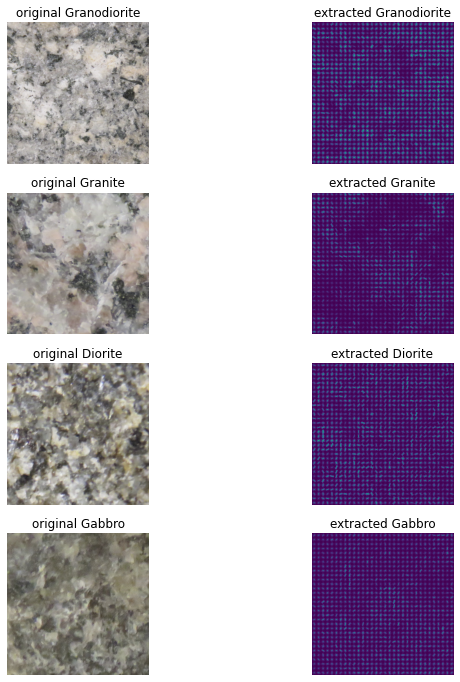

In [10]:
print('Color extraction')

k = list(labels.keys())
v = list(labels.values())

rows = len(labels)
columns = 2

images = [x_tr[0], data_plot[0], x_tr[13], data_plot[13],
         x_tr[26], data_plot[26], x_tr[37], data_plot[37]]
tittles = ['original ' + k[v.index(y_tr[0])], 'extracted ' + k[v.index(y_tr[0])],
           'original ' + k[v.index(y_tr[13])], 'extracted ' + k[v.index(y_tr[13])],
           'original ' + k[v.index(y_tr[26])], 'extracted ' + k[v.index(y_tr[26])],
           'original ' + k[v.index(y_tr[37])], 'extracted ' + k[v.index(y_tr[37])]]

fig, plots = plt.subplots(rows, columns, figsize=(10,12))
for row in plots:
    for ax in row:
        ax.imshow(images.pop(0))
        ax.set_title(tittles.pop(0))
        ax.axis('off')
plt.show(fig)

## 5. Create model
### 5.a SVM Linear

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(C=100.0, random_state=42)

### 5.b SVM

In [ ]:
from sklearn.svm import SVC
# define support vector classifier
model = SVC(kernel='linear', probability=True, random_state=42)

### 5.c Deep Neural Network

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [12]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, IMAGE_SIZE[1], IMAGE_SIZE[0]) 
else: 
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

num_classes = len(labels)

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape = input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), metrics=["accuracy"])

## 6. Train model
### 6.a SVM

In [ ]:
data_extracted_tr = np.array(data_extracted_tr)
nsamples, nx, ny = data_extracted_tr.shape
data_extracted_tr = data_extracted_tr.reshape((nsamples,nx*ny))

data_extracted_tst = np.array(data_extracted_tst)
nsamples, nx, ny = data_extracted_tst.shape
data_extracted_tst = data_extracted_tst.reshape((nsamples,nx*ny))

print('data extracted shape:', np.shape(data_extracted_tr))

In [ ]:
model.fit(data_extracted_tr, y_tr)

### 6.b DNN Data Generator samples

In [ ]:
from livelossplot.tf_keras import PlotLossesCallback

trainingmodel = model.fit_generator(train_generator, steps_per_epoch = steps // BATCH_SIZE, epochs = epochs, validation_data = validation_generator, validation_steps = 200 // BATCH_SIZE, callbacks=[PlotLossesCallback()], verbose=1) 
print(model.summary())

### 6.c DNN cv2 samples

In [13]:
model.fit(list(data_extracted_tr), list(y_tr))

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'int'>"})

## 7. Test model
### 7.a cv2 data samples

In [ ]:
# Test model
from sklearn import metrics

predictions = model.predict(data_extracted_tst)
print("Model accuracy:", metrics.accuracy_score(y_tst, predictions))
print(metrics.classification_report(y_tst,predictions, target_names=labels))

### 7.b Image data generator samples

In [ ]:
test_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

#with tf.device('/gpu:0'):
predictions = model.predict_generator(validation_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

report = metrics.classification_report(true_classes, predicted_classes, target_names=labels)
print(report)  